# Fit Lineages in ONS Data

© 2022 Thomas House and Roberto Cahuantzi

Code for analysis of lineage prevalences and growth rates in the ONS CIS data.


In [6]:
%matplotlib inline
from os.path import join
from itertools import cycle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D as L2D
import matplotlib.colors as mc
import matplotlib.patheffects as pe
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
import colorsys
import time
from datetime import datetime, timedelta
import scipy.optimize as op
from tqdm.notebook import tqdm
from lineage import *

In [7]:
dict_lineages = {'B.1.177': ['B.1.177'], 
                 'B.1.1.7 - Alpha': ['B.1.1.7'], 
                 'B.1.617.2 - Delta': ['B.1.617.2', 'AY.4.2'],
                 'BA.1 - Omicron': ['BA.1', 'BA.1.1'],
                 'BA.2 - Omicron': ['BA.2', 'BA.2.75'],
                 'BA.4&5 - Omicron': ['BA.4', 'BA.5'],
                    }

lineage_colours = {'Other'      :'#C0507D', 
                   'B.1.177'           :'#5F469A',
                   'B.1.1.7 - Alpha'   :'#CE59C6',
                   'B.1.351 - Beta'    :'#6DD156',
                   'P.1 - Gamma'       :'#D34C3A',
                   'B.1.617.2 - Delta' :'#3D3142',
                   'P.2 - Zeta'        :'#85CEB3',
                   'B.1.525 - Eta'     :'#C6CD56',
                   'BA.1 - Omicron'    :'#516D3E',
                   'BA.2 - Omicron'    :'#CDADAA',
                   'BA.3 - Omicron'    :'#7A39D6',
                   'BA.4 - Omicron'    :'#7C95C3',
                   'BA.5 - Omicron'    :'#794131',
                   'BA.4&5 - Omicron'  :'#a8a4ed',
                   }

base_dir = './'

np.random.seed(397)

In [8]:
df_data = pd.read_csv('ONS_day_lineage.csv')

In [10]:
df_data.head()

,Day,paper_lineage
0,173,B.1.177
1,175,B.1.177
2,175,Other
3,174,Other
4,175,B.1.177


In [11]:
t_ranges = {'B.1.177': [125, 305], 
            'B.1.1.7 - Alpha': [180, 450],
            'B.1.617.2 - Delta': [360, 640], 
            'BA.1 - Omicron': [580, 750],
            'BA.2 - Omicron': [615, 810], 
            'BA.4&5 - Omicron': [715, 890],
           }

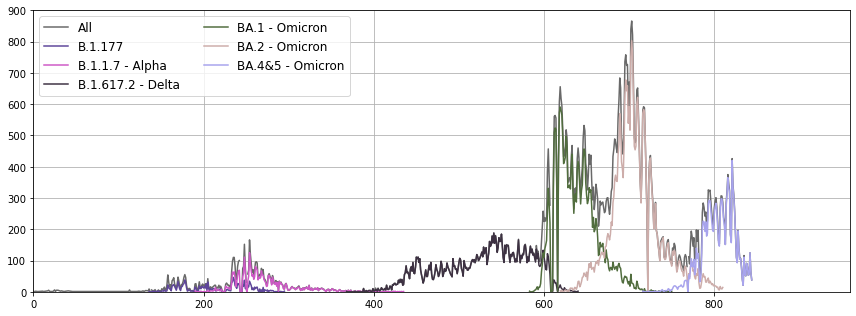

In [13]:
df_counts = LineageCounts(df_data, dict_lineages, t_ranges)

fig = plt.figure(figsize=(12,4.5))
ax = fig.add_subplot()
x_counts = df_counts.index
y_counts = df_counts.iloc[:,0].T.values.reshape(-1)
ax.plot(x_counts, y_counts, label='All', 
         c='dimgrey')

for i, column in enumerate(df_counts.columns[1:]):
    Z = df_counts[column]
    x_z = Z.index
    y_z = Z.T.values.reshape(-1)
    ax.plot(x_z, y_z, label=column, 
             c=lineage_colours[column])

ax.legend(fontsize=12, ncol=2)
ax.set_ylim(0, 900); plt.xlim(0, 959)
ax.grid()
plt.tight_layout()

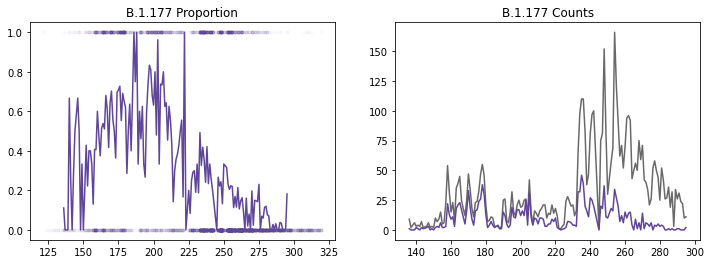

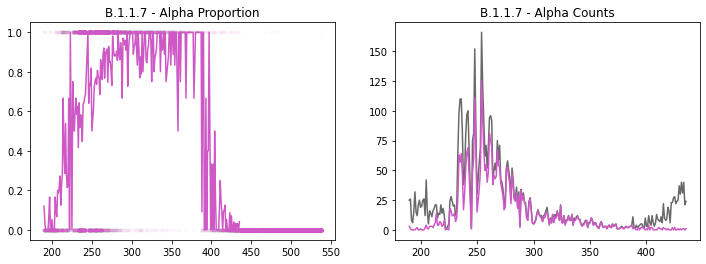

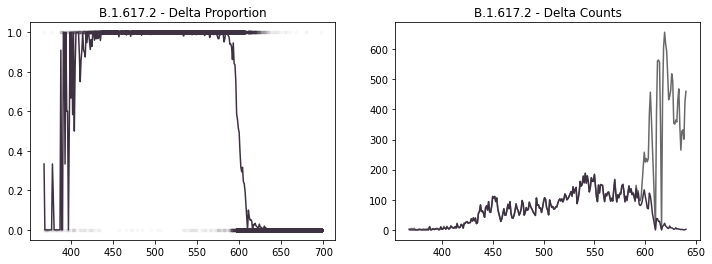

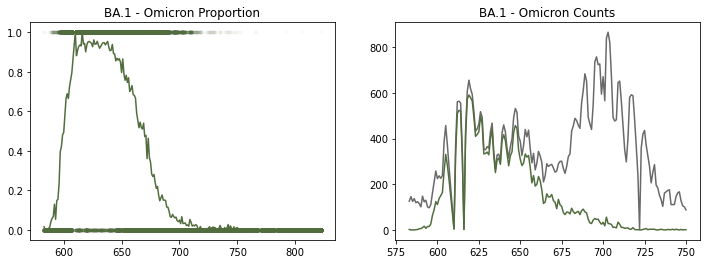

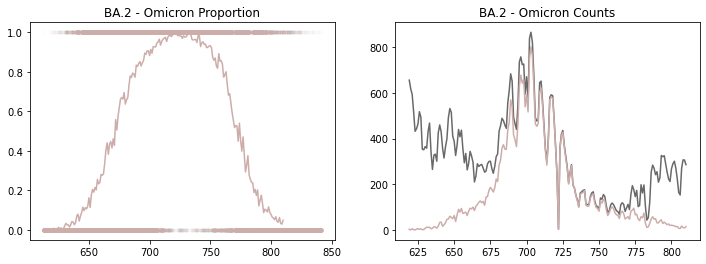

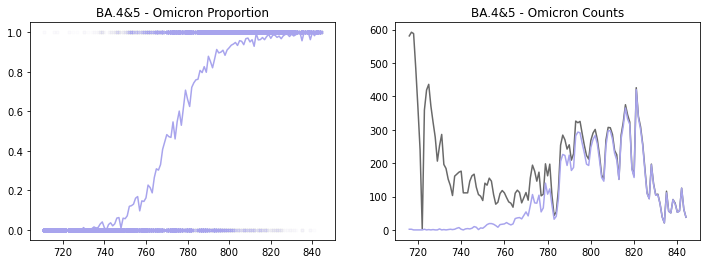

In [14]:
df_probabilities = LineageProbabilities(df_data, dict_lineages, t_ranges)
occurences = LineageOccurences(df_data, dict_lineages)
    
for i, lineage in enumerate(df_counts.columns[1:]):
    
    columns = ['All', lineage]
    df = df_counts.loc[:, columns]
    df.dropna(inplace=True)
    
    x_probabilities = df_probabilities[f'P_{lineage}'].dropna().index
    y1_lineage, y2_lineage = df.T.values
    x_lineage = df.index
    p_lineage = df_probabilities[f'P_{lineage}'].dropna()
    x_data, y_data = occurences[lineage].T.values
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.scatter(x_data, y_data,marker='.', 
                alpha=0.02, color=lineage_colours[lineage])
    plt.plot(x_probabilities, p_lineage, 
             color=lineage_colours[lineage])
    plt.title(f'{lineage} Proportion')
    
    plt.subplot(1,2,2)
    plt.plot(x_lineage, y1_lineage, 
             color='dimgrey')
    plt.plot(x_lineage, y2_lineage, 
             color=lineage_colours[lineage])
    plt.title(f'{lineage} Counts')

In [61]:
data = GPFitting(occurences, df_counts)

Loaded data for B.1.177
Running Gaussian process classification.
Main fit done. Bootstrap progress:


  0%|          | 0/200 [00:00<?, ?it/s]

Loaded data for B.1.1.7 - Alpha
Running Gaussian process classification.
Main fit done. Bootstrap progress:


  0%|          | 0/200 [00:00<?, ?it/s]

Loaded data for B.1.617.2 - Delta
Too large for GPC (55521 samples). Running Gaussian Process Regression.
Main fit done. Bootstrap progress:


  0%|          | 0/200 [00:00<?, ?it/s]

Loaded data for BA.1 - Omicron
Too large for GPC (73569 samples). Running Gaussian Process Regression.
Main fit done. Bootstrap progress:


  0%|          | 0/200 [00:00<?, ?it/s]

Loaded data for BA.2 - Omicron
Too large for GPC (70020 samples). Running Gaussian Process Regression.
Main fit done. Bootstrap progress:


  0%|          | 0/200 [00:00<?, ?it/s]

Loaded data for BA.4&5 - Omicron
Too large for GPC (26877 samples). Running Gaussian Process Regression.
Main fit done. Bootstrap progress:


  0%|          | 0/200 [00:00<?, ?it/s]

# Plot

In [17]:
hls_colours = {k: colorsys.rgb_to_hls(*mc.to_rgb(v)) 
               for k, v in lineage_colours.items()}
dot_colours = {k: mc.to_hex(colorsys.hls_to_rgb(v[0], 0.67 * v[1], v[2])) 
               for k, v in hls_colours.items()}
boot_colours = {k: mc.to_hex(colorsys.hls_to_rgb(v[0], 0.5 * (v[1]+1), v[2])) 
                for k, v in hls_colours.items()}

keys = dict_lineages.keys()
lineage_markers = {k: m for k, m in zip(keys, cycle(L2D.filled_markers))}

tmi = 125
tma = 850
m = len(dot_colours)-1

lineages = df_counts.columns[1:]

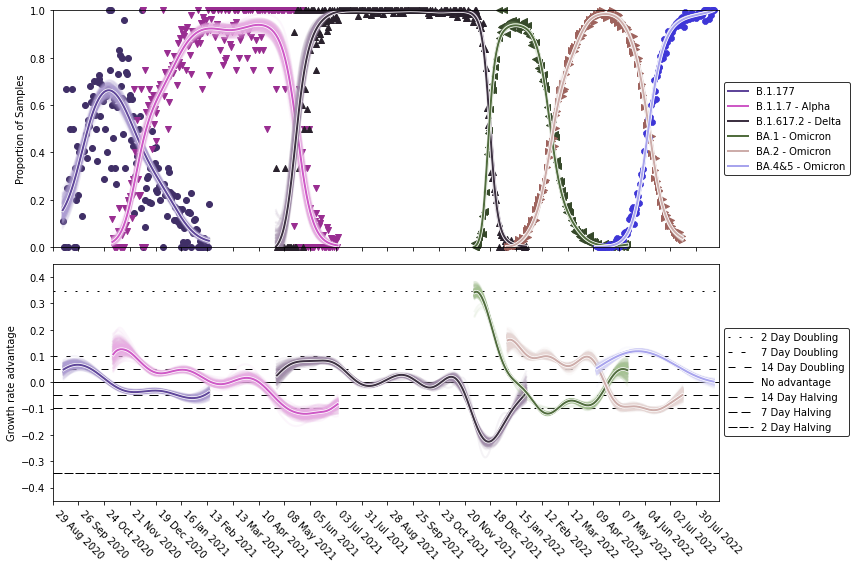

In [18]:
days = np.arange(tmi, tma, 28)

day_one = pd.Timestamp("2020-04-26")
days_labels = [(day_one+timedelta(days=int(d))).strftime("%d %b %Y") 
               for d in (days)]

fig = plt.figure(figsize=(12,8))

ax0 = fig.add_subplot(2,1,1)

for i, lineage in enumerate(lineages):
    
    X0 = df_probabilities[f'P_{lineage}'].dropna().index
    p = df_probabilities[f'P_{lineage}'].dropna().values
    ax0.scatter(X0, p, c=dot_colours[lineage], marker=lineage_markers[lineage], 
                clip_on=False)

    boots = data['Pi_boot'][lineage].columns
    for j in boots:
        Pi = data['Pi_boot'][lineage].loc[:, j]
        X0 = data['Pi_boot'][lineage].index
        ax0.plot(X0, Pi, c=boot_colours[lineage], lw=2, alpha=0.1)

    Pi_line = data['Pi_store'][lineage].plot(c=lineage_colours[lineage], lw=2, 
                                   label=lineage, ax=ax0)
    Pi_line.lines[-1].set_path_effects([pe.Stroke(linewidth=3.5, foreground='w'), 
                                       pe.Normal()]);
    
ax0.set_ylabel('Proportion of Samples')
ax0.set_xlim([tmi, tma])
ax0.set_ylim([0,1])
ax0.set_xticks(days,[])

ax0.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),
           bbox_transform=ax0.transAxes, edgecolor='k',)

ax1 = fig.add_subplot(2,1,2)
for i, lineage in enumerate(lineages):
    
    X0 = data['r_boot'][lineage].index
    boots = data['r_boot'][lineage].columns
    for j in boots:
        r = data['r_boot'][lineage].loc[:,j]
        r_len = len(r)-1
        ax1.plot(X0, r, c=boot_colours[lineage], lw=2, alpha=0.1)
    r_line = data['r_store'][lineage].plot(c=lineage_colours[lineage], lw=2, 
                                           label='_hidden', ax=ax1)
    r_line.lines[-1].set_path_effects([pe.Stroke(linewidth=3.5, foreground='w'), 
                                       pe.Normal()]);

line_ys = [np.log(2)/2, np.log(2)/7, np.log(2)/14, 
           0,
          -np.log(2)/14, -np.log(2)/7, -np.log(2)/2]
line_styles = [(0, (2, 9)), (0, (4, 9)), (0, (7, 9)), 
               (0, (9, 0)),
               (0, (9, 7)), (0, (9, 4)), (0, (9, 2))]
line_labels = ['2 Day Doubling', '7 Day Doubling', '14 Day Doubling', 
               'No advantage', 
               '14 Day Halving', '7 Day Halving', '2 Day Halving']

[ax1.axhline(y, ls=ls, label=label, zorder=0, c='k', lw=1) 
 for y, ls, label in zip(line_ys, line_styles, line_labels)]
    
ax1.set_ylabel('Growth rate advantage')
ax1.set_xlim([tmi, tma])
ax1.set_ylim([-0.45,0.45])
ax1.set_xticks(days, days_labels, rotation=-45, ha="left")
ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),
           bbox_transform=ax1.transAxes, edgecolor='k',
          handlelength=2.5)

plt.tight_layout()
plt.show()

## Save Text Files

In [19]:
output_dir = './output'

In [20]:
df_counts.to_csv(join(output_dir, 'Counts.csv'))
df_probabilities.to_csv(join(output_dir, 'Probabilities.csv'))
data['Pi_store'].to_csv(join(output_dir, 'Pi_store.csv'))
data['r_store'].to_csv(join(output_dir, 'r_store.csv'))
for lin in data['Pi_boot']:
    data['Pi_boot'][lin].to_csv(join(output_dir, lin + '_Pi_boot.csv'))
for lin in data['r_boot']:
    data['r_boot'][lin].to_csv(join(output_dir, lin + '_r_boot.csv'))